In [438]:
# Standard Imports
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pickle
import eli5

# Transformers
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

# Modeling Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, classification_report
from IPython.display import display, Markdown

# Pipelines
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as PipeImb
from imblearn.pipeline import make_pipeline


# Machine Learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier


#Validation methods
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedStratifiedKFold

#Sampling methods
from imblearn.over_sampling import SMOTENC


In [439]:
#Look at pipeline and what it does
# from sklearn import set_config
#set_config(display='diagram')
#display(search2)

# User defined functions

In [440]:
def a_xy_split(dataframe,y_name,test_size=.3):
   
    #Get xy split and train/test data ready
    X = dataframe.drop([y_name], axis=1)
    y = dataframe.attrition
    y = LabelEncoder().fit_transform(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size,random_state=42)

    #Prep numerical and other column types for use in preprocessor
    numerical=X.select_dtypes(include='number')
    categorical=X.select_dtypes(include='object')
    numerical_columns=list(numerical.columns)
    categorical_columns=list(categorical.columns)
    columns=list(X.columns)
    cat_col_bool=[True if x in categorical_columns else False for x in columns]

    return X_train, X_test, y_train, y_test,numerical_columns,categorical_columns,cat_col_bool

In [441]:
def b_preprocessors():
    #Creating ss transformer to scale the continuous numerical data with StandardScaler()
    ss = Pipeline(steps=[('ss', StandardScaler())])
    #--------------------------------------------------------------------
    #Creating ohe transformer to encode the categorical data with OneHotEncoder()
    ohe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', drop='first'))])
    #--------------------------------------------------------------------
    #Creating preprocess column transformer to combine the ss and ohe pipelines
    preprocess = ColumnTransformer(
                        transformers=[
                            ('num', ss, numerical_columns),
                            ('cat', ohe, categorical_columns)
                        ])
    return preprocess



In [442]:
def c_get_standard_params():
        #Creating parameter grid for Random Forest
        rand_forest_parms = {'classifier__n_estimators': [100, 300, 500],
                'classifier__max_depth':[6, 25, 50, 70],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 10]}
        
        decision_tree_params = {'classifier__max_depth':[6, 25, 50, 70],
                'classifier__min_samples_split': [2, 5, 10],
                'classifier__min_samples_leaf': [1, 2, 10],
                'classifier__max_features': [1,2,5,10]}

        xgb_params = { 'classifier__max_depth': [3,6,10],
                'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
                'classifier__n_estimators': [100, 500, 1000],
                'classifier__colsample_bytree': [0.3, 0.7],
                'classifier__subsample':[.6,1]}

        log_regress_params={'classifier__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                        'classifier__penalty':['none','l1','l2','elasticnet'],
                        'classifier__C':[100,10,1.0, 0.1,0.01]}
        
        knn_params={'classifier__n_neighbors':[1, 5, 10],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan', 'minkowski']}

        gaussian_params={'classifier__var_smoothing': [1e-11, 1e-10, 1e-9]}

        bagging_params= {'classifier__base_estimator__max_depth' : [1, 2, 3, 4, 5],
        'classifier__max_samples' : [0.05, 0.1, 0.2, 0.5]}

        return rand_forest_parms,xgb_params,log_regress_params,knn_params,gaussian_params,bagging_params,decision_tree_params

In [443]:
def _evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    f1 = f1_score(y,y_hat)
    print('Accuracy: ', accuracy)
    print('Recall: ', recall)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()



# Stack formula

In [444]:
def _get_stacking():
    # define the base models
    level0 = list()
    level0.append(('dt',DecisionTreeClassifier(max_depth= 6, max_features=1, min_samples_leaf= 2, min_samples_split= 10)))
    #level0.append(('xgb', XGBClassifier()))
    #level0.append(('svm', SVC(random_state=42)))
    #level0.append(('bag',BaggingClassifier(LogisticRegression(),n_estimators=5,bootstrap=False)))
    level0.append(('lr', LogisticRegression(random_state=1234)))
    level0.append(('knn', KNeighborsClassifier(metric='manhattan',n_neighbors=10,weights='distance')))
    # define meta learner model
    level1 = LogisticRegression(random_state=1234)
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [445]:
def d_check_best_model(smote_type="nc"):
    stack=_get_stacking()
    models=[LogisticRegression(),RandomForestClassifier(),XGBClassifier(),KNeighborsClassifier(),DecisionTreeClassifier(),stack,SVC(),GaussianNB(),BaggingClassifier()]

    for i in models:
        print (i)
        e_cross_validate_grid(preprocess,i,cv=KFold(),grid_search=False,smote_type=smote_type)
        print()

In [446]:
def e_cross_validate_grid(preprocessor, classifier, smote_type='NC', param_grid="none", cv="none", scoring="recall", conf_matrix=False, grid_search=False):
    cv = cv

    #Set correct pipeline for use in the formula
    pipeline = PipeImb(steps=[
    ('preprocess', preprocessor),
    ('classifier', classifier)])


    if smote_type.lower()=="nc":
        pipeline.steps.insert(0,('smote',SMOTENC(categorical_features=X_train.dtypes==object,random_state=1234,n_jobs=-1)))


    if grid_search==True:
        search = GridSearchCV(pipeline, param_grid=param_grid, cv=cv,scoring=scoring)
    else:
        search=pipeline
# Run train and validation methods, print average result for each
    train_acc = []
    train_rec=[]
    train_prec=[]
    test_acc = []
    test_rec=[]
    test_prec=[]
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        search.fit(X_t, y_t)
        y_hat_t = search.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        train_rec.append(recall_score(y_t,y_hat_t))
        train_prec.append(precision_score(y_t,y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = search.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
        test_rec.append(recall_score(y_val, y_hat_val))
        test_prec.append(precision_score(y_val, y_hat_val))

    if conf_matrix==True:
        print("Validation set confusion matrix")
        print(_evaluation(y_val, y_hat_val))
        print()
    print('Avg Training Accuracy: {}'.format(np.mean(train_acc)))
    print("Avg Training Recall: {}".format(np.mean(train_rec)))
    print("Avg Training Precision: {}".format(np.mean(train_prec)))
    print()
    print('Avg Validation Accuracy: {}'.format(np.mean(test_acc)))
    print("Avg Validation Recall: {}".format(np.mean(test_rec)))
    print("Avg Validation Precision: {}".format(np.mean(test_prec)))
    print()

# If grid search used, print best estimator's features
    if (grid_search==True):
        ohe_cols = list(search.best_estimator_.named_steps['preprocess'].named_transformers_['cat'].named_steps['ohe'].get_feature_names_out(
        input_features=categorical_columns))
        num_feats = list(numerical_columns)
        num_feats.extend(ohe_cols)
        feat_imp = eli5.explain_weights_df(search.best_estimator_.named_steps['classifier'], top=10, feature_names=num_feats)
        print(feat_imp)
        print()
        print('Grid Search Best Params:')
        print()
        print(search.best_params_)
    return search


In [447]:
def g_validate_using_test(preprocessor, classifier, grid, cv):
    final_pipeline = GridSearchCV(PipeImb(steps=[
            ('preprocess', preprocessor),
            ('classifier', classifier)
        ]), grid, cv=cv)
    #Fit and predict on train data
    final_pipeline.fit(X_train, y_train)

    train_pred = final_pipeline.best_estimator_.predict(X_train)
    #train_pred=final_pipeline.predict(X_train)

    print('Evaluation on training data \n')
    print(_evaluation(y_train, train_pred))
    print('\n')
    #Predict on test data

    test_pred = final_pipeline.best_estimator_.predict(X_test)
    #test_pred = final_pipeline.predict(X_test)
    print('Evaluation on testing data \n')
    print(_evaluation(y_test, test_pred))

In [448]:
def f_validate_pipeline_on_test(pipeline):
    test_pred = pipeline.predict(X_test)
    #test_pred = final_pipeline.predict(X_test)
    print('Evaluation on testing data \n')
    print(_evaluation(y_test, test_pred))

# Code here

In [513]:
df=pd.read_csv(r"Data\4b.IBM_data_cleaned_dropped - Copy - Copy.csv")
df2=df[df['age']<42].copy()
df3=df2[df2['jobrole'].isin(['laboratory technician','sales representative'])].copy()

In [514]:
#df3['workbeforecompany']=df3['totalworkingyears']-df3['yearsatcompany']
#df3['engagement']=((df3['worklifebalance']+df3['jobinvolvement']+df3['environmentsatisfaction']+df3['jobsatisfaction'])/4)
#df3['embedded']=df3['stockoptionlevel']*df3['totalworkingyears']*df3['salaryquartile']*df3['yearsatcompany']
#df3.drop(columns=['businesstravel','educationfield','gender','percentsalaryhike','yearswithcurrmanager','yearssincelastpromotion','trainingtimeslastyear'],axis=1,inplace=True)

In [515]:
y_name='attrition'
X_train, X_test, y_train, y_test,numerical_columns,categorical_columns,cat_col_bool=a_xy_split(df2,y_name,test_size=.3)
#X_train, X_test, y_train, y_test,numerical_columns,categorical_columns,cat_col_bool=a_xy_split(df2,y_name,test_size=.2)
preprocess=b_preprocessors()
rand_forest_parms,xgb_params,log_regress_params,knn_params,gaussian_params,bagging_params,decision_tree_params=c_get_standard_params()
stack=_get_stacking()

In [516]:
d_check_best_model()

LogisticRegression()
Avg Training Accuracy: 0.8652505561409672
Avg Training Recall: 0.7093397085124342
Avg Training Precision: 0.6379918892753117

Avg Validation Accuracy: 0.8303513186096356
Avg Validation Recall: 0.6435675618411991
Avg Validation Precision: 0.5520904335420465


RandomForestClassifier()
Avg Training Accuracy: 1.0
Avg Training Recall: 1.0
Avg Training Precision: 1.0

Avg Validation Accuracy: 0.828981455595937
Avg Validation Recall: 0.4320648339424758
Avg Validation Precision: 0.6233201581027668


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
     

In [487]:
pipeline=e_cross_validate_grid(preprocess,stack,scoring='recall', cv=KFold(),grid_search=False,conf_matrix=False)

Avg Training Accuracy: 0.9924606918238995
Avg Training Recall: 0.9752971923414087
Avg Training Precision: 1.0

Avg Validation Accuracy: 0.8287179487179486
Avg Validation Recall: 0.6346861471861472
Avg Validation Precision: 0.7418831168831169



In [519]:
pipeline=e_cross_validate_grid(preprocess,LogisticRegression(),scoring='recall', cv=KFold(),grid_search=False,conf_matrix=False)

Avg Training Accuracy: 0.8652505561409672
Avg Training Recall: 0.7093397085124342
Avg Training Precision: 0.6379918892753117

Avg Validation Accuracy: 0.8303513186096356
Avg Validation Recall: 0.6435675618411991
Avg Validation Precision: 0.5520904335420465



Validation set confusion matrix
Accuracy:  0.7808219178082192
Recall:  0.6111111111111112
Precision:  0.55
F1:  0.5789473684210527


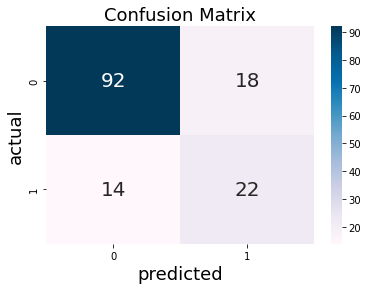

None

Avg Training Accuracy: 0.9955549701440113
Avg Training Recall: 0.99486779422419
Avg Training Precision: 0.982916289318746

Avg Validation Accuracy: 0.7810548877085081
Avg Validation Recall: 0.5759670180270848
Avg Validation Precision: 0.45476744186046514



In [504]:
pipeline=e_cross_validate_grid(preprocess,BaggingClassifier(base_estimator=KNeighborsClassifier(metric='manhattan',n_neighbors=10,weights='distance')),scoring='recall', cv=KFold(),param_grid=knn_params,grid_search=False,conf_matrix=True)

C:\Users\micha\anaconda3\envs\urchin\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\micha\anaconda3\envs\urchin\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\micha\anaconda3\envs\urchin\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\micha\anaconda3\envs\urchin\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\micha\anaconda3\envs\urchin\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\micha\anaconda3\envs\urchin\lib\site-pack

Validation set confusion matrix
Accuracy:  0.8287671232876712
Recall:  0.6388888888888888
Precision:  0.6571428571428571
F1:  0.647887323943662


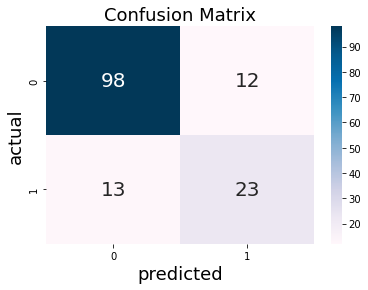

None

Avg Training Accuracy: 0.8652499707294229
Avg Training Recall: 0.7149397140699376
Avg Training Precision: 0.6370502091763746

Avg Validation Accuracy: 0.838561177895816
Avg Validation Recall: 0.661987428712679
Avg Validation Precision: 0.5720764293178087



In [531]:
#One of better predictors
pipeline=e_cross_validate_grid(preprocess,BaggingClassifier(base_estimator=LogisticRegression(max_iter=100,penalty='l1',solver='saga'),n_estimators=15,bootstrap=False),scoring='recall', cv=KFold(),param_grid=knn_params,grid_search=False,conf_matrix=True)

Evaluation on testing data 

Accuracy:  0.8630573248407644
Recall:  0.673469387755102
Precision:  0.55
F1:  0.6055045871559633


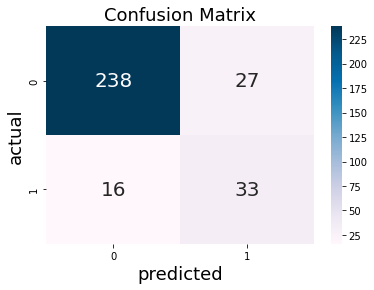

None


In [532]:
f_validate_pipeline_on_test(pipeline)